In [1]:
# Impor tensorflow and numpy
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import math as m
import time
# For validation
from sklearn.metrics import confusion_matrix
import itertools



# For plotting
from matplotlib import pyplot as plt

# Add the library to the system path
import os,sys
se2cnn_source =  os.path.join(os.getcwd(),'..')
if se2cnn_source not in sys.path:
    sys.path.append(se2cnn_source)

# Import the library
import se2cnn.layers

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# check tf can see the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5632840052964895297
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9844031488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9045951375971650367
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:06:00.0, compute capability: 8.9"
]


In [3]:
# Xavier's/He-Rang-Zhen-Sun initialization for layers that are followed ReLU
def weight_initializer(n_in, n_out):
    return tf.random_normal_initializer(mean=0.0, stddev=m.sqrt(2.0 / (n_in))
    )

def size_of(tensor) :
    # Multiply elements one by one
    result = 1
    for x in tensor.get_shape().as_list():
         result = result * x 
    return result 

## Load and Format Dataset

In [4]:
code_distance = 7
error_rate = 1000

observations = 70000

dataset = np.load(f'test-datasets/HL_data_{code_distance}_{error_rate}_{observations}.npy')

nontest, test = np.split(dataset, [60000])

nontest_data_unzipped = nontest[:, :code_distance**2 *2]
# last 4 columns are the labels
nontest_labels= nontest[:, -4:]

test_data_unzipped = test[:, :code_distance**2 *2]
test_labels= test[:, -4:]



In [5]:
from Datavis import visualize_observation

# visualizing observation and label
# red: x-error, yellow: z-error, green: x and z error, blue: stabilizer activation

observation_index = 0

#visualize_observation(nontest[observation_index][:-4])
print(nontest[observation_index][-4:])


[0 0 0 0]


## Zip Together Syndromes

In [6]:
# new np ndarrays
nontest_data = []

test_data = []

for observation in nontest_data_unzipped:

    # split in half
    observation = observation.reshape(code_distance *2, code_distance)
    first_half = observation[:code_distance]
    second_half = observation[code_distance:]
    # zip them together
    observation = np.array(list(zip(first_half, second_half))).flatten()


    nontest_data.append(observation)

for observation in test_data_unzipped:
    # split in half
    observation = observation.reshape(code_distance *2, code_distance)
    first_half = observation[:code_distance]
    second_half = observation[code_distance:]
    # zip them together
    observation = np.array(list(zip(first_half, second_half))).flatten()

    test_data.append(observation)

nontest_data = np.array(nontest_data)
test_data = np.array(test_data)

print(nontest_data.shape)
print(test_data.shape)


(60000, 98)
(10000, 98)


## Closed Surface Padding

In [7]:
temp_nt = nontest_data
temp_t = test_data

nontest_data = []
test_data = []

kernellll = 3

pad_size = kernellll - 1

for observation in temp_nt:
    # reshape to 2D
    observation = observation.reshape(2*code_distance, code_distance)

    # left pad is last two columns of observation
    left_pad = observation[:,-pad_size:]
    # right pad is first two columns of observation
    right_pad = observation[:,:pad_size]    
    # pad the observation
    observation = np.hstack((left_pad, observation))

    bottom_pad = observation[:pad_size,:]
    top_pad = observation[-pad_size:,:]

    observation = np.vstack((top_pad, observation))

    # flatten the observation
    observation = observation.flatten()

    nontest_data.append(observation)

for observation in temp_t:
    # reshape to 2D
    observation = observation.reshape(2*code_distance, code_distance)

    # left pad is last two columns of observation
    right_pad = observation[:,:pad_size]
    # right pad is first two columns of observation
    left_pad = observation[:,-pad_size:]

    # pad the observation
    observation = np.hstack((left_pad, observation))

    bottom_pad = observation[:pad_size,:]
    top_pad = observation[-pad_size:,:]

    observation = np.vstack((top_pad, observation))

    # flatten the observation
    observation = observation.flatten()

    test_data.append(observation)

nontest_data = np.array(nontest_data)
test_data = np.array(test_data)


In [8]:
# Reshape to 2D multi-channel images
nontest_data_2D = nontest_data.reshape(len(nontest_data), code_distance*2 +  pad_size, code_distance +  pad_size, 1) # data shape here
test_data_2D = test_data.reshape(len(test_data), code_distance*2 + pad_size, code_distance + pad_size, 1)

print(f"nontest_data_2D.shape = {nontest_data_2D.shape}")


nontest_data_2D.shape = (60000, 16, 9, 1)


In [9]:
print(nontest_data[0])

print(nontest_data_2D[0,:,:,0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [10]:
print(test_data[0])

print(test_data_2D[0,:,:,0])\

print(test_labels[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
[0 0 0 0]


# one-hot encode all labels

In [11]:
nontest_labels_encoded = np.array([int(''.join(map(str,single_label)),2) for single_label in nontest_labels])
test_labels_encoded = np.array([int(''.join(map(str,single_label)),2) for single_label in test_labels])

print(nontest_labels[:5])
print(nontest_labels_encoded[:5])

print(test_labels[:5])
print(test_labels_encoded[:5])



[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0 0 0 0 0]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0 0 0 0 0]


In [12]:

print(test_labels[:5])
# head of labels
print(test_labels_encoded[:5])


[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0 0 0 0 0]


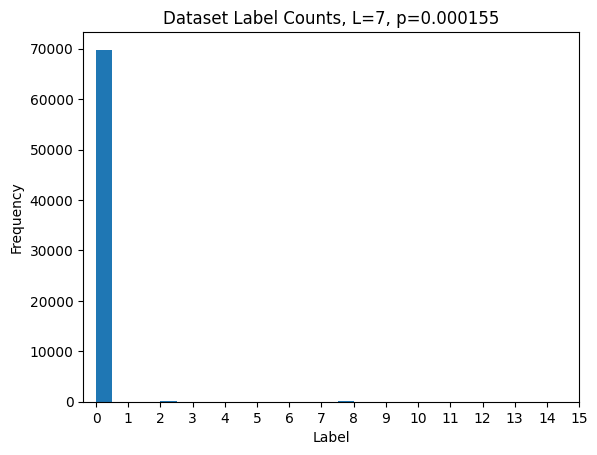

In [13]:
# histogram of nontest_labels_encoded

dataset_encoded = np.concatenate((nontest_labels_encoded, test_labels_encoded))
plt.title(f"Dataset Label Counts, L={code_distance}, p={0.155/error_rate}")
plt.hist(dataset_encoded, bins=16)
# show all x ticks
plt.xticks(np.arange(16))
# axis labels
plt.xlabel("Label")
plt.ylabel("Frequency")

plt.show()




## Define GCNN Structure

In [14]:
Ntheta = 4 # Kernel size in angular direction
Nxy = kernellll     # Kernel size in spatial direction
Nc = 4     # Number of channels in the initial layer

graph = tf.Graph()
graph.as_default()
tf.compat.v1.reset_default_graph()

inputs_ph = tf.placeholder( dtype = tf.float32, shape = [
    None, 
    nontest_data_2D.shape[1], 
    nontest_data_2D.shape[2], 
    nontest_data_2D.shape[3]] )
labels_ph = tf.placeholder( dtype = tf.int32, shape = [None,] )


tensor_in = inputs_ph
Nc_in = 1

kernels={}

In [15]:
print(inputs_ph.shape)
print(labels_ph.shape)

(?, 16, 9, 1)
(?,)


### Layer 1

In [16]:
with tf.variable_scope("Layer_{}".format(1)) as _scope:
    ## Settings
    Nc_out = Nc

    ## Perform lifting convolution
    # The kernels used in the lifting layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # Lifting layer
    tensor_out, kernels_formatted = se2cnn.layers.z2_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw,
                            orientations_nb = Ntheta)
    # Add bias
    tensor_out = tensor_out + bias
    
    ## Perform (spatial) max-pooling
    #tensor_out = se2cnn.layers.spatial_max_pool( input_tensor=tensor_out, nbOrientations=Ntheta)
    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

Z2-SE2N BASE KERNEL SHAPE: (3, 3, 1, 4)
Z2-SE2N ROTATED KERNEL SET SHAPE: (4, 3, 3, 1, 4)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 14, 7, 4, 4)


In [17]:
print(tensor_in.get_shape())

(?, 14, 7, 4, 4)


### Layer 2

In [18]:
with tf.variable_scope("Layer_{}".format(2)) as _scope:
    ## Settings
    Nc_out = 2*Nc

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # The group convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias
    
    #tensor_out = se2cnn.layers.spatial_max_pool( input_tensor=tensor_out, nbOrientations=Ntheta)

    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)
    
    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (3, 3, 4, 4, 8)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (4, 3, 3, 4, 4, 8)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 12, 5, 4, 8)


In [19]:
print(tensor_in.get_shape())

(?, 12, 5, 4, 8)


### Layer 3

In [20]:
with tf.variable_scope("Layer_{}".format(3)) as _scope:
    ## Settings
    Nc_out = 4*Nc

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # The group convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias

    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)
    
    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (3, 3, 4, 8, 16)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (4, 3, 3, 4, 8, 16)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 10, 3, 4, 16)


In [21]:
print(tensor_in.get_shape())

(?, 10, 3, 4, 16)


### Layer 4

In [22]:
with tf.variable_scope("Layer_{}".format(4)) as _scope:
    ## Settings
    Nc_out = 8*Nc

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [Nxy,Nxy,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(Nxy*Nxy*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))
    # The group convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias
    
    
    ## Apply ReLU
    tensor_out = tf.nn.relu(tensor_out)
    
    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out
    
    ## Save kernels for inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (3, 3, 4, 16, 32)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (4, 3, 3, 4, 16, 32)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 8, 1, 4, 32)


In [23]:
print(tensor_in.get_shape())

(?, 8, 1, 4, 32)


### Layer 5

### Layer 6

In [24]:
# create mapping matrix
identity = np.identity(4)
# swap 2n and 3rd rows
identity[[1, 2]] = identity[[2, 1]]
rearr = np.kron(identity, identity)


with tf.variable_scope("Layer_{}".format(5)) as _scope:
    ## Settings
    Nc_out = 16

    ## Perform group convolution
    # The kernels used in the group convolution layer
    kernels_raw = tf.get_variable(
                        'kernel', 
                        [1,1,Ntheta,Nc_in,Nc_out],
                        initializer=weight_initializer(1*1*Ntheta*Nc_in,Nc_out))
    tf.add_to_collection('raw_kernels', kernels_raw)
    bias = tf.get_variable( # Same bias for all orientations
                        "bias",
                        [1, 1, 1, 1, Nc_out], 
                        initializer=tf.constant_initializer(value=0.01))

    
    ## Convolution layer
    tensor_out, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel = kernels_raw)
    tensor_out = tensor_out + bias

    print(tensor_out.get_shape())
    
    ## The output logits
    logits = tensor_out[:,0,0,:,:] # reduces shape to tensor 

    print(logits.get_shape())
    
    logits = logits[:,0,:] + logits[:,1,:] @ rearr + logits[:,2,:] + logits[:,3,:] @ rearr

    predictions = tf.argmax(input=logits, axis=1)
    probabilities = tf.nn.softmax(logits)
    
    ## Save the kernels for later inspection
    kernels[_scope.name] = kernels_formatted

SE2N-SE2N BASE KERNEL SHAPE: (1, 1, 4, 32, 16)
SE2N-SE2N ROTATED KERNEL SET SHAPE: (4, 1, 1, 4, 32, 16)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 8, 1, 4, 16)
(?, 8, 1, 4, 16)
(?, 4, 16)


In [25]:
print(logits.get_shape())

(?, 16)


## Loss Function and Optimizers

In [26]:
# Cross-entropy loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels_ph, logits=logits)

In [27]:
#-- Define the l2 loss 
weightDecay=5e-4
# Get the raw kernels
variables_wd = tf.get_collection('raw_kernels')
print('-----')
print('RAW kernel shapes:')
for v in variables_wd: print( "[{}]: {}, total nr of weights = {}".format(v.name, v.get_shape(), size_of(v)))
print('-----')
loss_l2 = weightDecay*sum([tf.nn.l2_loss(ker) for ker in variables_wd])

-----
RAW kernel shapes:
[Layer_1/kernel:0]: (3, 3, 1, 4), total nr of weights = 36
[Layer_2/kernel:0]: (3, 3, 4, 4, 8), total nr of weights = 1152
[Layer_3/kernel:0]: (3, 3, 4, 8, 16), total nr of weights = 4608
[Layer_4/kernel:0]: (3, 3, 4, 16, 32), total nr of weights = 18432
[Layer_5/kernel:0]: (1, 1, 4, 32, 16), total nr of weights = 2048
-----


In [28]:
# Configure the Training Op (for TRAIN mode)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

train_op = optimizer.minimize(
    loss=loss + loss_l2,
    global_step=tf.train.get_global_step())

In [29]:
#-- Start the (GPU) session
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

In [30]:
batch_size=100
n_epochs=100

In [31]:
# first 60k observations are training data
nontest_data_2D_train = nontest_data_2D[:50000]
nontest_labels_encoded_train = nontest_labels_encoded[:50000]

# last 10k observations are validation data
nontest_data_2D_val = nontest_data_2D[50000:]
nontest_labels_encoded_val = nontest_labels_encoded[50000:]

# test data
test_data_2D = test_data_2D
test_labels_encoded = test_labels_encoded

patience = 30

train_loss = {}
val_loss = {}
min_val = np.inf
for epoch_nr in range(1, n_epochs+1):
    loss_average = 0
    data = nontest_data_2D_train
    labels = nontest_labels_encoded_train
    # KBatch settings
    NItPerEpoch = m.floor(len(data)/batch_size) #number of iterations per epoch
    samples=np.random.permutation(len(data))
    # Loop over dataset
    tStart = time.time()
    for iteration in range(NItPerEpoch):
        feed_dict = {
                inputs_ph: np.array(data[samples[iteration*batch_size:(iteration+1)*batch_size]]),
                labels_ph: np.array(labels[samples[iteration*batch_size:(iteration+1)*batch_size]])
                }
        operators_output = session.run([ loss , train_op ], feed_dict)
        loss_average += operators_output[0]/NItPerEpoch

    # Validation loss
    val_loss_average = 0
    data = nontest_data_2D_val
    labels = nontest_labels_encoded_val
    # KBatch settings
    NItPerEpoch = m.floor(len(data)/batch_size) #number of iterations per epoch
    samples=np.random.permutation(len(data))
    # Loop over dataset
    for iteration in range(NItPerEpoch):
        feed_dict = {
                inputs_ph: np.array(data[samples[iteration*batch_size:(iteration+1)*batch_size]]),
                labels_ph: np.array(labels[samples[iteration*batch_size:(iteration+1)*batch_size]])
                }
        operators_output = session.run([ loss ], feed_dict)
        val_loss_average += operators_output[0]/NItPerEpoch


    tElapsed = time.time() - tStart

    train_loss[epoch_nr] = loss_average
    val_loss[epoch_nr] = val_loss_average

    if val_loss_average < min_val:
        min_val = val_loss_average
        print('Validation loss improved... Saving model...')
        saver = tf.train.Saver()
        save_path = saver.save(session, f"models/gcnn_{code_distance}_{error_rate}_{observations}.ckpt")
        min_val_epoch = epoch_nr

    if val_loss_average > min_val:
        if epoch_nr - min_val_epoch > patience:
            print(f'Validation loss has not improved for {patience} epochs... Stopping training...')
            break

    

    if epoch_nr < 10:
        print('Epoch ' , epoch_nr , ' finished... Average loss = ' , round(loss_average,4) , ', time = ',round(tElapsed,4))
    else:
        print('Epoch' , epoch_nr , ' finished... Average loss = ' , round(loss_average,4) , ', time = ',round(tElapsed,4))

    print ('Validation loss = ', round(val_loss_average,4))

# load the best model
saver = tf.train.Saver()
saver.restore(session, f"models/gcnn_{code_distance}_{error_rate}_{observations}.ckpt")


    

Validation loss improved... Saving model...
Epoch  1  finished... Average loss =  0.0607 , time =  7.5281
Validation loss =  0.0134
Validation loss improved... Saving model...
Epoch  2  finished... Average loss =  0.0133 , time =  2.8963
Validation loss =  0.0129
Epoch  3  finished... Average loss =  0.0119 , time =  2.8965
Validation loss =  0.0134
Validation loss improved... Saving model...
Epoch  4  finished... Average loss =  0.0116 , time =  2.9729
Validation loss =  0.0113
Epoch  5  finished... Average loss =  0.0103 , time =  2.8769
Validation loss =  0.012
Validation loss improved... Saving model...
Epoch  6  finished... Average loss =  0.0105 , time =  2.6726
Validation loss =  0.0101
Epoch  7  finished... Average loss =  0.0094 , time =  2.9487
Validation loss =  0.0116
Epoch  8  finished... Average loss =  0.0095 , time =  2.8211
Validation loss =  0.0105
Validation loss improved... Saving model...
Epoch  9  finished... Average loss =  0.0094 , time =  2.7336
Validation loss

## Validation

In [32]:
import time
batch_size = 1000
labels_pred = []
# start time
tStart = time.time()
for i in range(round(len(test_data_2D)/batch_size)):
    [ labels_pred_batch ] = session.run([ predictions ], { inputs_ph: test_data_2D[i*batch_size:(i+1)*batch_size] })
    labels_pred = labels_pred + list(labels_pred_batch)
# end time
tElapsed = time.time() - tStart
print('Time elapsed for prediction = ',round(tElapsed,4),' seconds')
labels_pred = np.array(labels_pred)

with open(f'gc/scores/ti_{code_distance}_{error_rate}.txt', 'a') as f:
    f.write(f"{tElapsed}\n")

Time elapsed for prediction =  0.3525  seconds


In [33]:
print(labels_pred[0:10])
print(test_labels_encoded[0:10])

with open(f'gc/scores/pr_{code_distance}_{error_rate}.txt', 'a') as f:
    for label in labels_pred:
        f.write(f"{label}\n")

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


Accuracy

In [34]:
ac_score = ((labels_pred - test_labels_encoded)**2==0).astype(float).mean()

with open(f"gc/scores/ac_{code_distance}_{error_rate}.txt", "a") as f:
    f.write(f'{ac_score}\n')

print('Accuracy = ', round(ac_score,4))

Accuracy =  0.9986


Total Errors

In [35]:
((labels_pred - test_labels_encoded)**2>0).astype(float).sum()

14.0

Error Rate

In [36]:
100*((labels_pred - test_labels_encoded)**2>0).astype(float).mean()

0.13999999999999999

Confusion matrix, without normalization


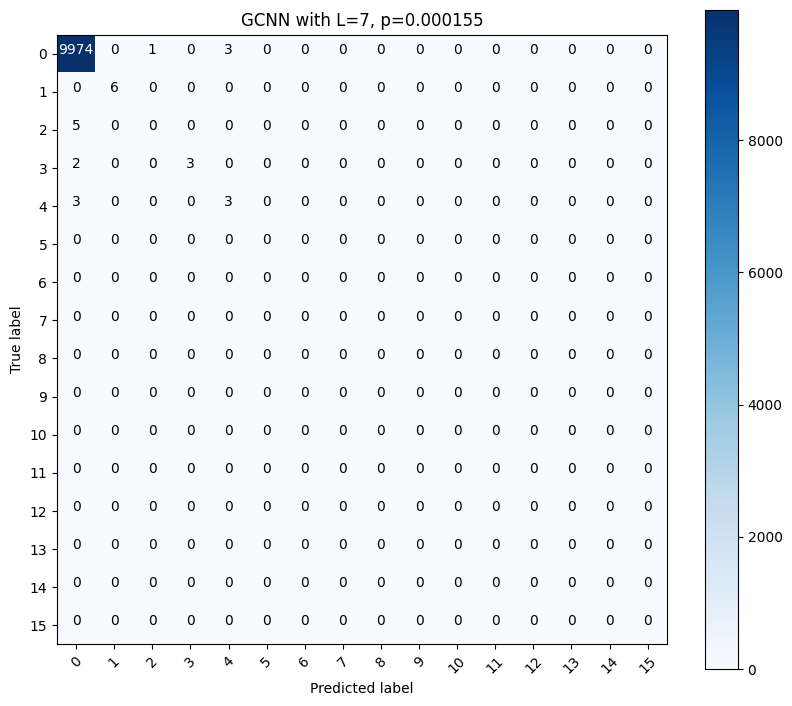

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=f'GCNN with L={code_distance}, p={0.155/error_rate}',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # make bigger
    plt.gcf().set_size_inches(8, 8)

    #plt.savefig(f"cms/cm_L_{code_distance}_p_{error_rate}.png")

    
    plt.show()



cm = confusion_matrix(test_labels_encoded, labels_pred)
if cm.shape[0] < 16:
    cm = np.pad(cm, (0, 16-cm.shape[0]), 'constant')
plot_confusion_matrix(cm, range(16))


In [38]:
# calculate the per class f1 score
cm = confusion_matrix(test_labels_encoded, labels_pred)
def f1_score(cm):
    f1 = []
    for i in range(len(cm)):
        tp = cm[i][i]
        fp = np.sum(cm[:,i]) - tp
        fn = np.sum(cm[i,:]) - tp
        f1.append(tp/(tp + 0.5*(fp + fn)))
    return f1

f1_scores = f1_score(cm)

print(f1_scores)

# save to file
with open(f"gc/scores/f1_{code_distance}_{error_rate}.txt", "a") as f:
    f.write(f'{f1_scores}\n')


[0.9992986674681895, 1.0, 0.0, 0.75, 0.5]


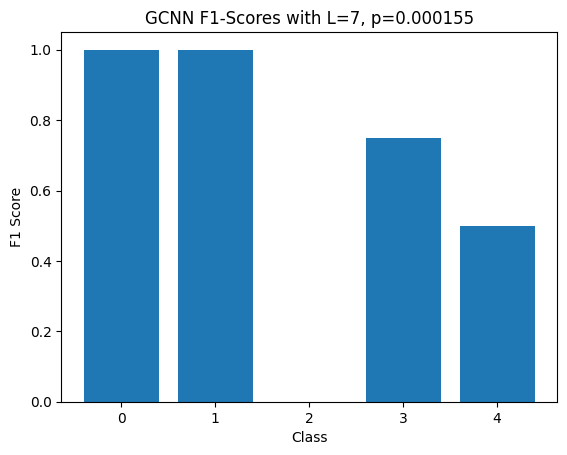

In [39]:
# plot the f1 score
plt.bar(range(cm.shape[0]), f1_score(cm))
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title(f'GCNN F1-Scores with L={code_distance}, p={0.155/error_rate}')
plt.xticks(range(cm.shape[0]))
plt.show()

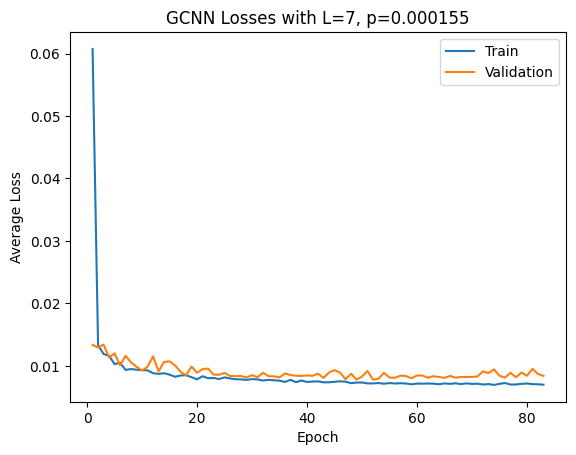

In [40]:
# plot losses
plt.plot(train_loss.keys(), train_loss.values())
plt.plot(val_loss.keys(), val_loss.values())
plt.legend(['Train', 'Validation'])

plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'GCNN Losses with L={code_distance}, p={0.155/error_rate}')

plt.xticks(np.arange(0, len(train_loss)+1, 20))


plt.show()